In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
Path = '../../data/firstRound_4h_normFalse_formatSeq.csv'

df_raw = pd.read_csv(Path)
df_raw.head(5)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,NaN,52.402431,NaN,61.622165,54.151485,56.058694,3.998246
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,NaN,40.072951,NaN,42.042854,45.432032,42.515946,2.213263
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,NaN,28.831559,NaN,24.487870,24.133637,25.817689,2.136029
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,NaN,43.093359,NaN,38.641958,38.049577,39.928298,2.251065
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,NaN,45.913214,NaN,44.352931,38.394865,42.887003,3.239660


In [3]:
Path = '../../data/firstRound_4h_normTrue_formatSeq.csv'

df_normalised = pd.read_csv(Path)
df_normalised.head(5)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,NaN,2.783529,NaN,3.260245,3.225496,3.089757,0.265769
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,NaN,1.678119,NaN,1.589655,2.374458,1.880744,0.429851
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,NaN,0.670263,NaN,0.091788,0.295688,0.352580,0.293404
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,NaN,1.948917,NaN,1.299476,1.653915,1.634102,0.325173
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,NaN,2.201733,NaN,1.786760,1.687616,1.892036,0.272748


In [4]:
print('raw data mean:')
df_raw.mean(axis = 0)

raw data mean:


Unnamed: 0    82.613333
Rep1          19.430768
Rep2          21.355608
Rep3          18.328426
Rep4          23.412110
Rep5          21.104113
AVERAGE       21.041324
STD            1.867289
dtype: float64

In [5]:
print('raw data std:')
df_raw.std(axis = 0)

raw data std:


Unnamed: 0    52.668112
Rep1          10.156944
Rep2          11.153762
Rep3          10.913377
Rep4          11.719995
Rep5          10.245670
AVERAGE       10.807507
STD            1.099764
dtype: float64

## Compare UCB recommendatiosn based on raw and normalised labels

In [6]:
# create all combos

combos = [] # 20-base
combos_6 = [] # 6-base
labels = []
char_sets = ['A', 'G', 'C', 'T']
design_len = 6

# to be changed
pre_design = 'TTTAAGA'
pos_design = 'TATACAT'

for combo in itertools.product(char_sets, repeat= design_len):
    
    combo = pre_design + ''.join(combo) + pos_design
    combos_6.append(''.join(combo))
    combos.append(combo)
    labels.append(math.inf)
    
assert len(combos) == len(char_sets) ** design_len
# len(combos)

In [7]:
todesign_data = np.asarray(list(zip(combos, labels))) # 20-base
todesign6_data = np.asarray(list(zip(combos_6, labels))) # 6-base

In [8]:
embedding = 'label'
# sum_spectrum_kernel_pw: spectrum kernels for [:7], [7:13], [13:] respectively

kernel = WeightedDegree_Kernel(l_list = [3])
alpha = 2 

num_rounds = 1 
num_exper = 1
num_rec = 100

### Raw

In [9]:
Path = '../../data/firstRound_4h_normFalse_formatSample.csv'

df_raw_sample = pd.read_csv(Path)
df_raw_sample.head(5)

,Unnamed: 0,Name,RBS,RBS6,AVERAGE,STD,Group,variable,label
0,0,RBS_1by1_0,TTTAAGAAGGAGATATACAT,AGGAGA,56.058694,3.998246,reference,Rep2,52.402431
1,1,RBS_1by1_1,CTTAAGAAGGAGATATACAT,AGGAGA,42.515946,2.213263,bps_noncore,Rep2,40.072951
2,2,RBS_1by1_2,GTTAAGAAGGAGATATACAT,AGGAGA,25.817689,2.136029,bps_noncore,Rep2,28.831559
3,3,RBS_1by1_3,ATTAAGAAGGAGATATACAT,AGGAGA,39.928298,2.251065,bps_noncore,Rep2,43.093359
4,4,RBS_1by1_4,TCTAAGAAGGAGATATACAT,AGGAGA,42.887003,3.239660,bps_noncore,Rep2,45.913214


beta:  18.689610922300982
[2681 1778 1599 2809 3066 2673 3359 2859 1643 3195 1750  251 2168 3028
 2807 1531 3019 2267 3707 1567 1147 2769 1611 1311 2772 1776 3031 1784
 3058 3323 1275 1658 2015 3056 2775  767 2623  731 1151 2667 3059 2635
 3064 1779 2283 3025 2299 2785 1595  747 1615 2682 2591 3041 2767 2810
 2799 1656 2802 2639 2774 2763 2555 3055 3030 2800 3057 2619 1777 2680
 2011 2808 1759 2027  639 2803 3199  635 2043 1791 1755 1771 2171 2801
 2783  763 3039 2175 2779 2815 2795 1663 3051 3035 2687 1659 3067 1787
 2683 2811]


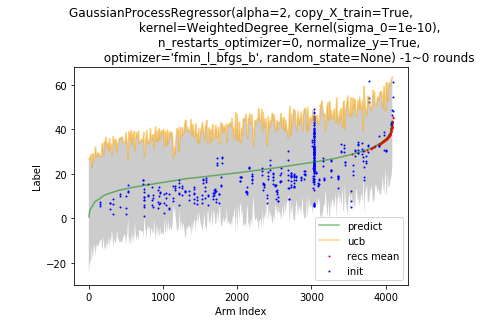

In [10]:
data_raw = np.asarray(df_raw_sample[['RBS', 'label']])

my_env_raw = Rewards_env(data_raw, embedding)
new_env = Rewards_env(todesign_data, embedding)

agent_raw = GPUCB(new_env, num_rounds, init_list = my_env_raw.rewards_dict, num_rec = num_rec,
          model = GaussianProcessRegressor(kernel = kernel, alpha = alpha, normalize_y =True))
rec_arms_raw = agent_raw.play(label_avaiable = False)

Text(0.5, 1.0, 'WD Distance Raw')

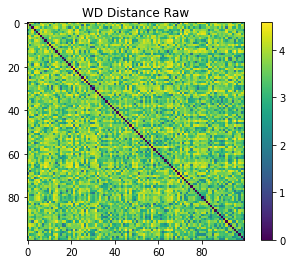

In [11]:
raw_rec_seq = todesign_data[np.asarray(rec_arms_raw),0]

wd_distance_raw = kernel.distance(raw_rec_seq, raw_rec_seq, plot_flag=True)
plt.imshow(wd_distance_raw, cmap = 'viridis')
plt.colorbar()
plt.title('WD Distance Raw')

### Nomalised 

In [12]:
Path = '../../data/firstRound_4h_normTrue_formatSample.csv'

df_normalised_sample = pd.read_csv(Path)
df_normalised_sample.head(5)

,Unnamed: 0,Name,RBS,RBS6,AVERAGE,STD,Group,variable,label
0,0,RBS_1by1_0,TTTAAGAAGGAGATATACAT,AGGAGA,3.089757,0.265769,reference,Rep2,2.783529
1,1,RBS_1by1_1,CTTAAGAAGGAGATATACAT,AGGAGA,1.880744,0.429851,bps_noncore,Rep2,1.678119
2,2,RBS_1by1_2,GTTAAGAAGGAGATATACAT,AGGAGA,0.352580,0.293404,bps_noncore,Rep2,0.670263
3,3,RBS_1by1_3,ATTAAGAAGGAGATATACAT,AGGAGA,1.634102,0.325173,bps_noncore,Rep2,1.948917
4,4,RBS_1by1_4,TCTAAGAAGGAGATATACAT,AGGAGA,1.892036,0.272748,bps_noncore,Rep2,2.201733


beta:  2
[2805 1778 1658 2168 1311 2539 3019 2681 3579 1567 2673 1599 2751 1151
 2859 1776 1784 3031 3058 1611 1643 2769 2587  753 3307 2772 3707 3056
  251 3025 1275 2267 2809 1531 2682 3064  767 2807 1615 3323 2635  731
 1656 3059 2775 3041 2799 2591 2623 2667 3055 2299 2767 2810 1779 3030
 2639 2785 1595 1759 2774 2763 2011 2283  747 2680  639 2802 2027 2555
 2800 3057 3199 2808 2619  635 1777 2043 1791 1755 2803 2171 3039 2783
 1771 2175  763 2801 2815 1663 2779 3035 2687 2795 1659 3051 3067 2683
 1787 2811]


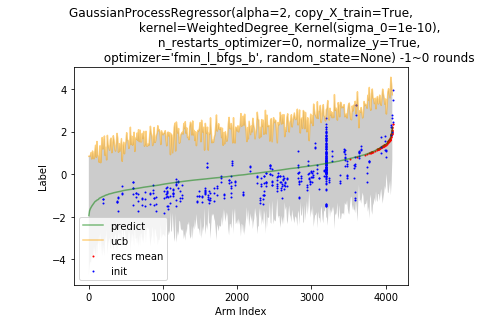

In [13]:
data_normalised  = np.asarray(df_normalised_sample[['RBS', 'label']])

my_env_normalised  = Rewards_env(data_normalised , embedding)

agent_normalised  = GPUCB(new_env, num_rounds, init_list = my_env_normalised .rewards_dict, num_rec = num_rec,
          model = GaussianProcessRegressor(kernel = kernel, alpha = alpha, normalize_y =True))
rec_arms_normalised = agent_normalised .play(label_avaiable = False)

In [14]:
from scipy import stats

stats.spearmanr(rec_arms_raw, rec_arms_normalised)

SpearmanrResult(correlation=-0.03414341434143414, pvalue=0.7359361190062261)

In [15]:
normalised_rec_seq = todesign_data[np.asarray(rec_arms_normalised),0]
normalised_rec_seq

array(['TTTAAGACCTTGGTATACAT', 'TTTAAGAGCTTACTATACAT',
       'TTTAAGAGCGTCCTATACAT', 'TTTAAGACAGTCATATACAT',
       'TTTAAGAGGAGTTTATACAT', 'TTTAAGACGTCCTTATACAT',
       'TTTAAGACTTACTTATACAT', 'TTTAAGACCGTCGTATACAT',
       'TTTAAGATGTTCTTATACAT', 'TTTAAGAGCAGTTTATACAT',
       'TTTAAGACCGTAGTATACAT', 'TTTAAGAGCATTTTATACAT',
       'TTTAAGACCCTTTTATACAT', 'TTTAAGAGAGTTTTATACAT',
       'TTTAAGACTACCTTATACAT', 'TTTAAGAGCTTAATATACAT',
       'TTTAAGAGCTTCATATACAT', 'TTTAAGACTTGGTTATACAT',
       'TTTAAGACTTTACTATACAT', 'TTTAAGAGCGACTTATACAT',
       'TTTAAGAGCGCCTTATACAT', 'TTTAAGACCTGAGTATACAT',
       'TTTAAGACCAGCTTATACAT', 'TTTAAGAACTTAGTATACAT',
       'TTTAAGATATCCTTATACAT', 'TTTAAGACCTGGATATACAT',
       'TTTAAGATCGTCTTATACAT', 'TTTAAGACTTTAATATACAT',
       'TTTAAGAAATTCTTATACAT', 'TTTAAGACTTGAGTATACAT',
       'TTTAAGAGATTCTTATACAT', 'TTTAAGACATGCTTATACAT',
       'TTTAAGACCTTCGTATACAT', 'TTTAAGAGGTTCTTATACAT',
       'TTTAAGACCGTCCTATACAT', 'TTTAAGACTTTCATATACAT',
       'TT

Text(0.5, 1.0, 'WD Distance Normalised')

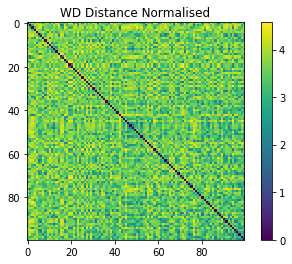

In [16]:
wd_distance_normalised = kernel.distance(normalised_rec_seq, normalised_rec_seq, plot_flag=True)
plt.imshow(wd_distance_normalised, cmap = 'viridis')
plt.colorbar()
plt.title('WD Distance Normalised')

In [20]:
stats.spearmanr(agent_raw.ucb, agent_normalised.ucb)

SpearmanrResult(correlation=0.9938440664378183, pvalue=0.0)

In [27]:
stats.spearmanr(np.sort(agent_raw.ucb)[::-1][:100], np.sort(agent_normalised.ucb)[::-1][:100])

SpearmanrResult(correlation=0.9999999999999999, pvalue=0.0)